# Algorithmic Fairness, Accountability, and Ethics, Spring 2024

## Mandatory Assignment 2

In [1]:
from folktables.acs import adult_filter
from folktables import ACSDataSource, BasicProblem, generate_categories
import numpy as np
import pandas as pd

DOWNLOAD = False

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=DOWNLOAD)


def adult_filter(data):
    """Mimic the filters in place for Adult data.
    Adult documentation notes: Extraction was done by Barry Becker from
    the 1994 Census database. A set of reasonably clean records was extracted
    using the following conditions:
    ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
    """
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    df = df[df["RAC1P"] < 3] ## keep only Whites and African-Americans
    return df


ACSIncomeNew = BasicProblem(
    features=[
        'AGEP',
        'COW',
        'SCHL',
        'MAR',
        'RELP',
        'WKHP',
        'PWGTP',
        'SEX',
        'RAC1P',
    ],
    target='PINCP',
    target_transform=lambda x: x > 25000,    
    group=['SEX', 'RAC1P'],
    preprocess=adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

definition_df = data_source.get_definitions(download=DOWNLOAD)
categories = generate_categories(features=ACSIncomeNew.features, definition_df=definition_df)
features, labels, groups = ACSIncomeNew.df_to_pandas(acs_data, categories=categories, dummies=True)

# Drop the "redundant" columns
features = features.drop(["RAC1P_White alone", 
                          "SEX_Male", 
                          "SCHL_1 or more years of college credit, no degree",  
                          "MAR_Divorced", 
                          "RELP_Adopted son or daughter",
                          'COW_Working without pay in family business or farm' ], axis = 1) 

print("Columns with the protected features:")
for i, f in enumerate(features.columns):
    if ("RAC1P" in f) or ("SEX" in f):
        print("Column ID: %s" %i, "(%s)"%f)
        
features.head()

Columns with the protected features:
Column ID: 54 (SEX_Female)
Column ID: 55 (RAC1P_Black or African American alone)


,AGEP,WKHP,PWGTP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,...,RELP_Other nonrelative,RELP_Other relative,RELP_Parent-in-law,RELP_Reference person,RELP_Roomer or boarder,RELP_Son-in-law or daughter-in-law,RELP_Stepson or stepdaughter,RELP_Unmarried partner,SEX_Female,RAC1P_Black or African American alone
0,21,20.0,52,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,65,8.0,33,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,33,40.0,53,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,18,18.0,106,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,27,50.0,23,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## The Task: 
Train three binary classifiers to predict income (label = True if income>$25k, otherwise label = False)

1. Train one classification model on the raw dataset and calculate its general 
accuracy, and respectively the accuracies for men and women and for 
different races. The model does not need to be fancy, logistic regression 
or Random Forest are completely fine choices. Remember to evaluate the 
model using cross validation.

In [2]:
## Imports

from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, f1_score, accuracy_score, make_scorer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from scipy.stats import  pearsonr, spearmanr
import scipy
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
## Set constants
seed = 0
np.random.seed(seed)

## This code is taken from solution to data debias exercises

# Split dataset into train and test sets ??Do we need this?
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, labels, groups, test_size=0.3, random_state=seed, shuffle=True)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Subsample for efficiency
## We considered stratifing here, as the data is unbalanced for white/african-american.

N = 20000  # Subsample size

# Generate random unique indices for subsampling
indices_train = np.random.choice(X_train.shape[0], N, replace=False)
indices_test = np.random.choice(X_test.shape[0], N, replace=False)

# Subsample using the random indices
### Train set
X_train = X_train.iloc[indices_train]
y_train = y_train.iloc[indices_train]
group_train = group_train.iloc[indices_train]
### Test set
X_test = X_test.iloc[indices_test]
y_test = y_test.iloc[indices_test]
group_test = group_test.iloc[indices_test]
group_test_dict = {
    'Males': group_test['SEX'] == 1,
    'Females': group_test['SEX'] == 2,
    'Whites': group_test['RAC1P'] == 1,
    'African-Americans': group_test['RAC1P'] == 2
}


# Print the counts
print(f"Number of Males in X_train: {np.sum(group_train['SEX'] == 1)}")
print(f"Number of Females in X_train: {np.sum(group_train['SEX'] == 2)}")
print(f"Number of Whites in X_train: {np.sum(group_train['RAC1P'] == 1)}")
print(f"Number of African Americans in X_train: {np.sum(group_train['RAC1P'] == 2)}")

Number of Males in X_train: 10555
Number of Females in X_train: 9445
Number of Whites in X_train: 18668
Number of African Americans in X_train: 1332


In [4]:
# Subset for protected and non-protected features
X_train_p = X_train.iloc[:, -2:]
X_test_p = X_test.iloc[:, -2:]
X_train_np = X_train.iloc[:, :-2]
X_test_np = X_test.iloc[:, :-2]

In [5]:
#Some helpful functions

def cross_validator(X, y, n=5):
    ''' Input:  X: training data
                y: true labels
                n: number of folds for cross validation, default=5
        Output: 2 dataframes, with accuracy and f1 scores, 
                per fold for overall and the 4 groups:
                male, female, white, african-american'''
    scaler = StandardScaler() ## We need to scale within the cross val step to avoid data leakage
    cls = LogisticRegression(penalty=None, max_iter=1000, random_state=seed)

    kfold = KFold(n, shuffle=True, random_state=seed)
    
    X_np = X.iloc[:, :-2]
    X_p = X.iloc[:, -2:]

    accuracies = []
    f1 = []
    X = np.array(X_np).reshape(-1, 54)
    X_p=np.array(X_p).reshape(-1, 2)
    y = np.array(y).reshape(-1, 1)

    for train_idx, test_idx in kfold.split(X):
        pipe = make_pipeline(scaler, cls)
        acc = []
        f1s = []
        X_train = X[train_idx]
        y_train = y[train_idx]
        X_test  = X[test_idx]
        y_test  = y[test_idx]
        X_p_test= X_p[test_idx]

        pipe.fit(X_train, y_train.ravel())
        y_hat = pipe.predict(X_test)

        acc.append(accuracy_score(y_test, y_hat))
        f1s.append(f1_score(y_test, y_hat))
        for i in [0,1]:
            for j in [0,1]:
                acc.append(accuracy_score(y_test[X_p_test[:,i]==j], y_hat[X_p_test[:,i]==j]))
                f1s.append(f1_score(y_test[X_p_test[:,i]==j], y_hat[X_p_test[:,i]==j]))
        accuracies.append(acc)
        f1.append(f1s)
    return pd.DataFrame(accuracies, columns=['General','Male','Female','White','AA']),\
           pd.DataFrame(f1, columns=['General','Male','Female','White','AA'])

def corr_mat(X):
    '''The code is adapted from solution to data debias exercises
    Takes a dataframe and computes the pearsons correlations, and their 
    statistical significance between all features,
    returning 2 arrays: correlations, and p_values'''
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Compute correlation matrix
    n_features = X.shape[1]

    corr_ = np.zeros((n_features, n_features))
    p_ = np.zeros((n_features, n_features))

    for i in range(n_features):
        for j in range(n_features):
            corr_[i,j], p_[i,j] = pearsonr(X[:,i], X[:,j])
            corr_ = np.nan_to_num(corr_, 0)
            # Handle NaN values in correlation coefficient by setting p-value to 1
            if np.isnan(corr_[i,j]):
                p_[i,j] = 1

    return corr_, p_

In [6]:
accs, f1s = cross_validator(X_train, y_train)

pd.DataFrame([accs.mean(), f1s.mean()], index=['Accuracy', 'F1']).T.round(4)

,Accuracy,F1
General,0.8209,0.8749
Male,0.8399,0.8937
Female,0.7995,0.8512
White,0.8225,0.8766
AA,0.7987,0.8475


# Task 2

2. Using the “fairer” (reprojected) versions of the dataset, build two classification models (see more below) and calculate: 
+ a) their overall accuracy, 
+ b) their accuracies split for men and women, and 
+ c) their accuracies split for different races. Subtasks: 
 
- Build one classification model trained on data reprojected using the 
de-correlation method from the paper “A Geometric Solution to Fair 
Representations”. Record your results and create a plot of how 
accuracies vary as functions of 𝜆Î[0,1].  
 
- Build one classification model using reprojected data from FairPCA.

## Task 2.1: A Geometric Solution to Fair Representations
### Correlations in Data

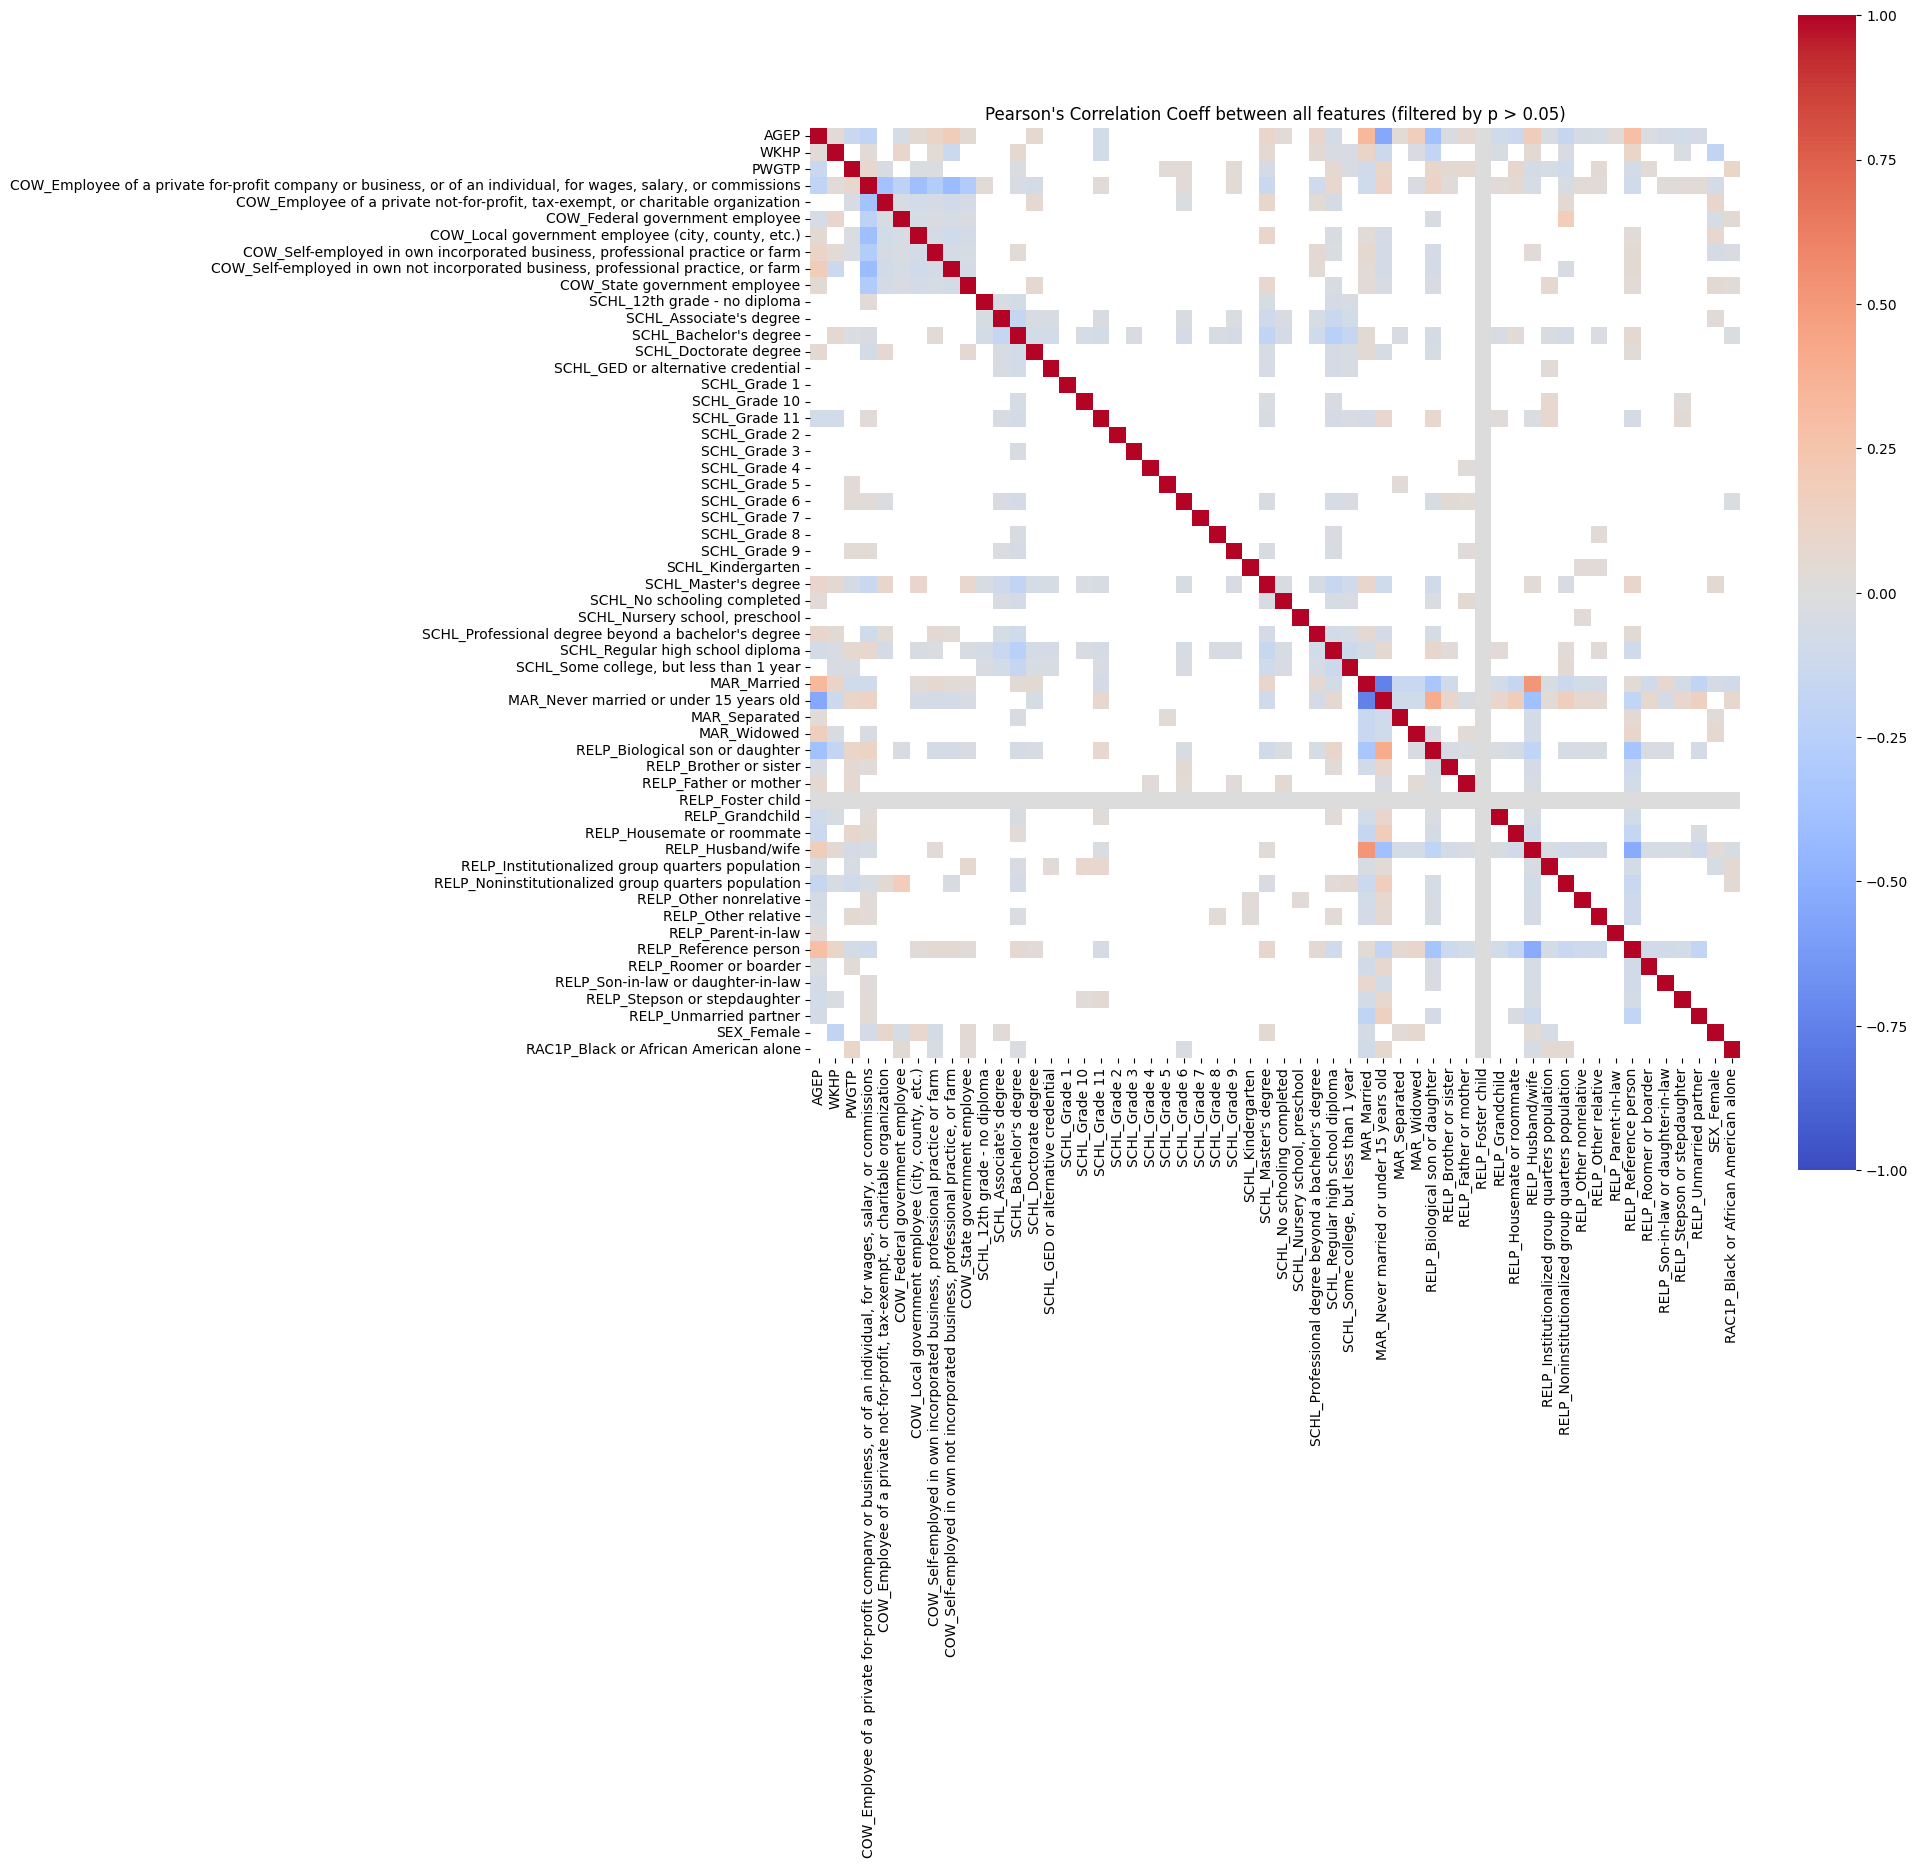

In [7]:
corr, p = corr_mat(X_train)

alpha = 0.05 # Significance level
corrected_alpha = alpha / (X_train.shape[1]**2/2) #bonferronni correction,

plt.figure(figsize=(15,15))
sns.heatmap(corr, cmap="coolwarm", xticklabels=features.columns, yticklabels=features.columns,
            square=True, vmin=-1, vmax=1, mask= p > corrected_alpha)

plt.title(f"Pearson's Correlation Coeff between all features (filtered by p > {alpha})")
plt.show()

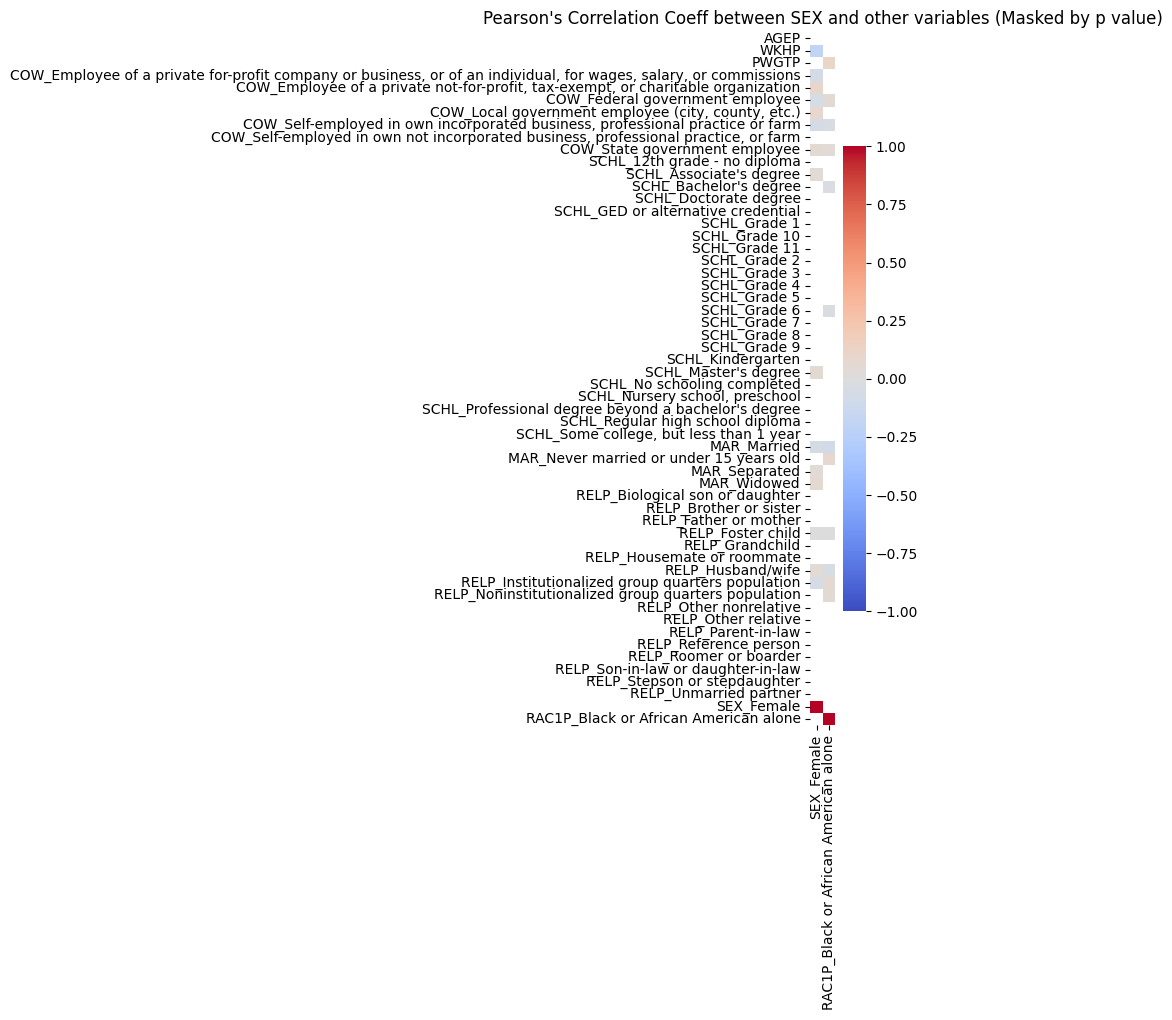

In [8]:
### Visualise columns of the correlation matrix that are associated only with protected features (see Lecture Slides)
plt.figure(figsize=(2,9))
sns.heatmap(corr[:, -2:], cmap="coolwarm", xticklabels=features.columns[-2:], yticklabels=features.columns,  
            mask = p[:, -2:]  > corrected_alpha, vmin=-1, vmax=1, square=True)
plt.title("Pearson's Correlation Coeff between SEX and other variables (Masked by p value)")
plt.show()

## 2.1.2 Simple Logistic Regression 

### Use a Geometric solution to debias data

In [9]:
#More helpful functions

def debias_features(X, l=0):
    '''based on exercises. Debias using de-correllation'''
     
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)

    #FunctionTransfomer makes it an array and I want it to be a dataFrame
    X = pd.DataFrame(X)
    
    #seperate protected attributes
    X_p = X.iloc[:, -2:]
    X_np = X.iloc[:, :-2]

    # Find the basis from the protected attributes
    orthbasis = scipy.linalg.orth(X_p)
    
    # Debias nonprotected features by projecting them onto the basis
    X_np_debiased = X_np - orthbasis @ orthbasis.T @ X_np

    # Return debiased nonprotected features, tempered by lambda: r′_j(λ) = r_j + λ⋅ (x_j− r_j)
    return X_np_debiased + l * (X_np - X_np_debiased)


def cross_validator_debiased(X, y, n=5, l=0):
    ''' Input:  X: training data
                y: true labels
                n: number of folds for cross validation, default=5
                l: lambda value to pass to the debiaser
        Output: 2 dataframes, with accuracy and f1 scores, 
                per fold for overall and the 4 groups:
                male, female, white, african-american
                
        note: scaling is moved to the debias_features function'''
    
    transformer = FunctionTransformer(debias_features, kw_args={'l': l}) #Debias as part of the pipeline to avoid leakage
    cls = LogisticRegression(penalty=None, max_iter=1000, random_state=seed)
  
    kfold = KFold(n, shuffle=True, random_state=seed)
    
    X_np = X.iloc[:, :-2]
    X_p = X.iloc[:, -2:]

    accuracies = []
    f1 = []
    pos_rates = []

    for train_idx, test_idx in kfold.split(X):

        pipe = make_pipeline(transformer, cls)
        acc = []
        f1s = []
        pr = []
        X_train = X_np.iloc[train_idx]
        y_train = y.iloc[train_idx]
        X_test  = X_np.iloc[test_idx]
        y_test  = y.iloc[test_idx]
        X_p_test= X_p.iloc[test_idx]

        pipe.fit(X_train, y_train)
        y_hat = pipe.predict(X_test)

        acc.append(accuracy_score(y_test, y_hat))
        f1s.append(f1_score(y_test, y_hat))
        pr.append(np.mean(y_hat))

        for i in [0,1]:
            for j in [0,1]:
                acc.append(accuracy_score(y_test[X_p_test.iloc[:,i]==j], y_hat[X_p_test.iloc[:,i]==j]))
                f1s.append(f1_score(y_test[X_p_test.iloc[:,i]==j], y_hat[X_p_test.iloc[:,i]==j]))
                pr.append(np.mean(y_hat[X_p_test.iloc[:,i]==j]))
        accuracies.append(acc)
        f1.append(f1s)
        pos_rates.append(pr)

    return pd.DataFrame(accuracies, columns=['General','Male','Female','White','AA']),\
           pd.DataFrame(f1, columns=['General','Male','Female','White','AA']),\
           pd.DataFrame(pos_rates, columns=['General','Male','Female','White','AA'])

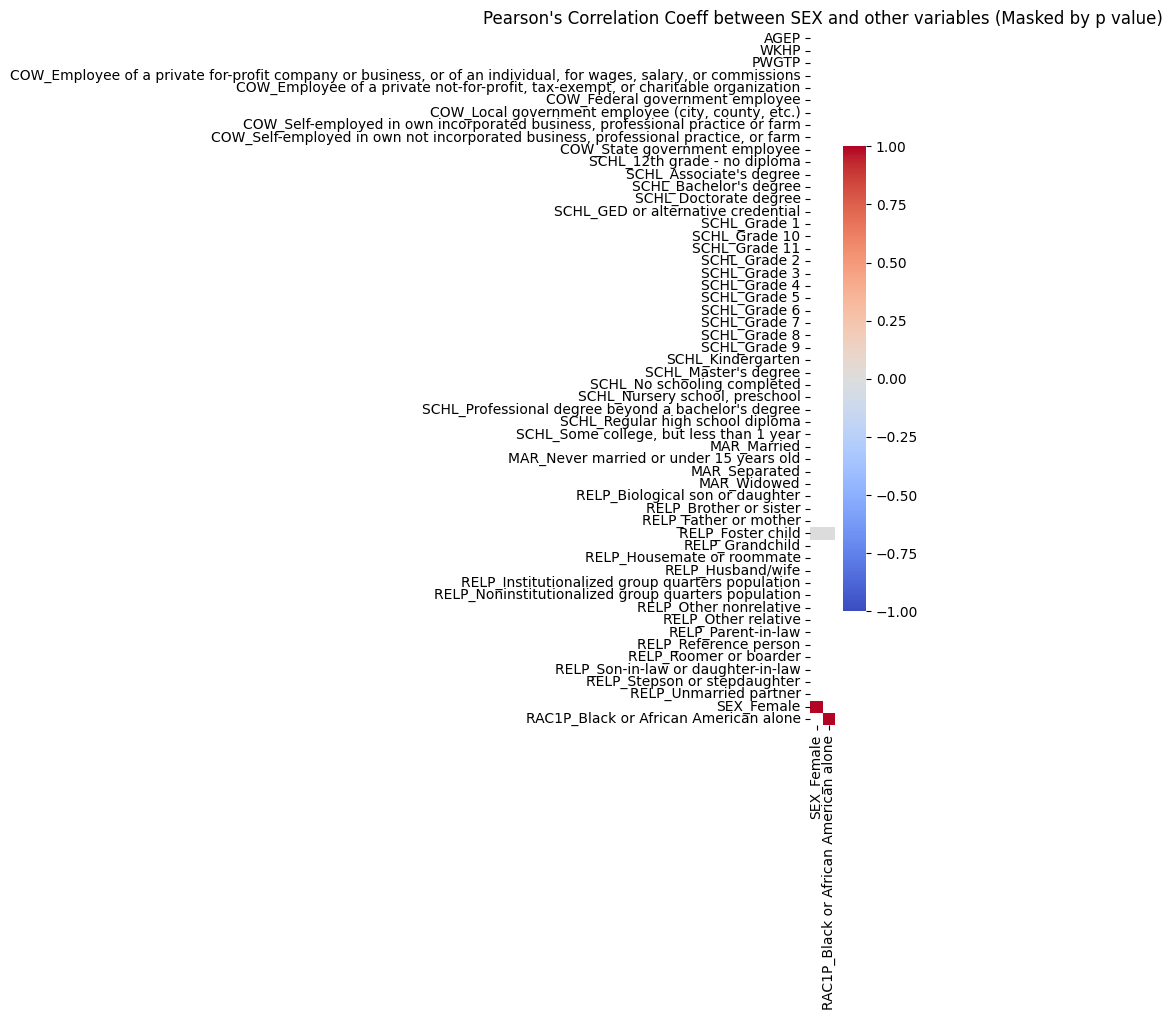

In [10]:
##Lambda = 0, so max decorrelating

X_train_np_debiased = debias_features(X_train.astype('float'))
X_train_debiased = np.concatenate([X_train_np_debiased, X_train.iloc[:, -2:]], axis=1)

corr2, p2 = corr_mat(X_train_debiased)

# Plot correlations with protected features
plt.figure(figsize=(2,9))
sns.heatmap(corr2[:, -2:], cmap="coolwarm", xticklabels=features.columns[-2:], yticklabels=features.columns,
            mask = p2[:, -2:]  > corrected_alpha, vmin=-1, vmax=1, square=True)
plt.title("Pearson's Correlation Coeff between SEX and other variables (Masked by p value)")
plt.show()

In [11]:
lambda_values = np.linspace(0, 1, 11)  # 11 values from 0 to 1
accuracies = pd.DataFrame(columns=['General','Male','Female','White','AA'])
f1_scores = pd.DataFrame(columns=['General','Male','Female','White','AA'])
positive_rates = pd.DataFrame(columns=['General','Male','Female','White','AA'])

y_hat_preds = []

for l in lambda_values:

    #usinng cross validation
    acs, fs, pos = cross_validator_debiased(X_train, y_train, n=5, l=l)
    accuracies = pd.concat([accuracies, pd.DataFrame(acs.mean()).T])
    f1_scores = pd.concat([f1_scores, pd.DataFrame(fs.mean()).T])
    positive_rates = pd.concat([positive_rates, pd.DataFrame(pos.mean()).T])


accuracies.index = lambda_values
f1_scores.index = lambda_values
positive_rates.index = lambda_values

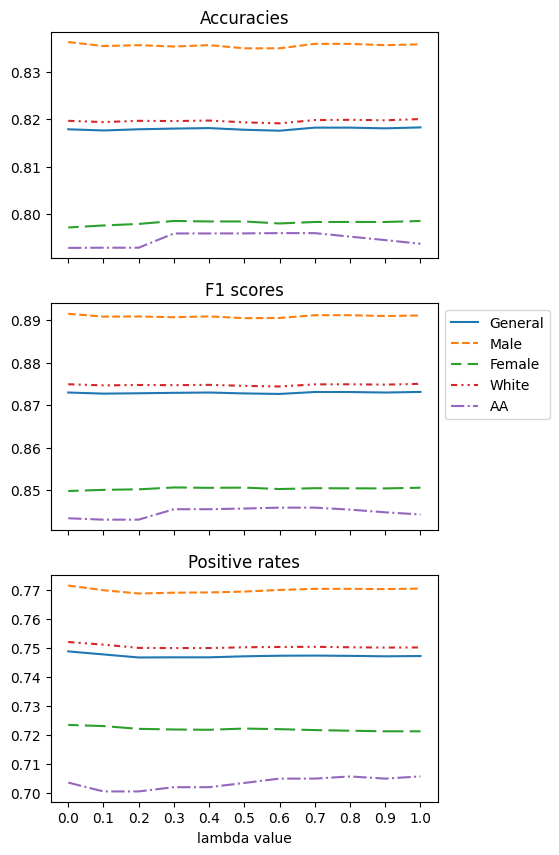

In [12]:
#Cross validation scores

_, ax = plt.subplots(3,1, figsize=(5, 10), sharex=True)
titles = ['Accuracies', 'F1 scores', 'Positive rates']
lines = ['solid', '--', (5, (10, 3)), (0, (3, 2, 1, 2, 1, 2)),'dashdot']


for i, df in enumerate([accuracies, f1_scores, positive_rates]):
    for j in range(5):
        ax[i].plot(df.iloc[:,j], linestyle=lines[j], label=df.columns[j])
        ax[i].set_title(f'{titles[i]}')

ax[1].legend(bbox_to_anchor=(1,1))

plt.xticks(lambda_values, labels=[round(x,1) for x in lambda_values])
plt.xlabel('lambda value')
plt.show()

In [13]:
accuracies.round(4)

,General,Male,Female,White,AA
0.0,0.8179,0.8364,0.7971,0.8197,0.7927
0.1,0.8177,0.8356,0.7975,0.8194,0.7928
0.2,0.8179,0.8357,0.7978,0.8197,0.7928
0.3,0.8181,0.8355,0.7985,0.8196,0.7958
0.4,0.8181,0.8357,0.7983,0.8197,0.7958
0.5,0.8178,0.8351,0.7983,0.8194,0.7958
0.6,0.8176,0.8351,0.7979,0.8192,0.7959
0.7,0.8182,0.8360,0.7982,0.8199,0.7959
0.8,0.8183,0.8360,0.7982,0.8199,0.7951
0.9,0.8181,0.8357,0.7982,0.8198,0.7944


# Task 2.1: Fair PCA

In [14]:
# Define a class for Fair PCA
class FairPCA:
    def __init__(self, Xs, p_idxs, n_components):
        self.fit(Xs, p_idxs, n_components)

    def fit(self, Xs, p_idxs, n_components):
        # Extract protected features
        Xs_p = Xs.iloc[:, p_idxs]

        # Compute projection matrix (U)
        # Set z
        Z = Xs_p

        # Compute orthonormal null-space spanned by Z.T @ Xs
        Z = Z - Z.mean(0) #center
        R = scipy.linalg.null_space(Z.T @ Xs)

        # Compute orthonormal eigenvectors (L)
        eig_vals, L = scipy.linalg.eig(R.T @ Xs.T @ Xs @ R)

        # U = R * Eigenvectors
        self.U = R @ L[:, :n_components]

    def project(self, Xs):
        # Project data into fair space using projection matrix U
        return Xs @ self.U
    

class NormalPCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.pca = PCA(n_components=n_components)

    def fit(self, X):
        self.pca.fit(X)

    def project(self, X):
        return self.pca.transform(X)
    

def debias_features_adjust_fairness_level(X_fair, X_pca, l=0):
    # r′j(λ) = rj + λ⋅ (xj− rj)
    return X_fair + l * (X_pca - X_fair)

def cross_validator_debiased_pca(X, y, n=5, l=0):
    ''' Input:  X: training data
                y: true labels
                n: number of folds for cross validation, default=5
                l: lambda value to pass to the debiaser
        Output: 2 dataframes, with accuracy and f1 scores, 
                per fold for overall and the 4 groups:
                male, female, white, african-american
                '''
    cls = LogisticRegression(penalty=None, max_iter=1000, random_state=seed)
  
    kfold = KFold(n, shuffle=True, random_state=seed)
    
    X_p = X.iloc[:, -2:]

    accuracies = []
    f1 = []
    pos_rates = []

    for train_idx, test_idx in kfold.split(X):
        acc = []
        f1s = []
        pr = []

        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]
        X_test  = X.iloc[test_idx]
        y_test  = y.iloc[test_idx]
        X_p_test= X_p.iloc[test_idx]

        fair = FairPCA(X_train, [54, 55], 30)
        norm = NormalPCA(30)
        norm.fit(X_train)

        X_train_debiased = fair.project(X_train)
        X_test_debiased = fair.project(X_test)
        X_train_pca = norm.project(X_train)
        X_test_pca = norm.project(X_test)

        X_train_final = debias_features_adjust_fairness_level(X_train_debiased, X_train_pca, l=l)
        X_test_final = debias_features_adjust_fairness_level(X_test_debiased, X_test_pca, l=l)


        cls.fit(X_train_final, y_train)
        y_hat = cls.predict(X_test_final)

        acc.append(accuracy_score(y_test, y_hat))
        f1s.append(f1_score(y_test, y_hat))
        pr.append(np.mean(y_hat))

        for i in [0,1]:
            for j in [0,1]:
                acc.append(accuracy_score(y_test[X_p_test.iloc[:,i]==j], y_hat[X_p_test.iloc[:,i]==j]))
                f1s.append(f1_score(y_test[X_p_test.iloc[:,i]==j], y_hat[X_p_test.iloc[:,i]==j]))
                pr.append(np.mean(y_hat[X_p_test.iloc[:,i]==j]))
        accuracies.append(acc)
        f1.append(f1s)
        pos_rates.append(pr)

    return pd.DataFrame(accuracies, columns=['General','Male','Female','White','AA']),\
           pd.DataFrame(f1, columns=['General','Male','Female','White','AA']),\
           pd.DataFrame(pos_rates, columns=['General','Male','Female','White','AA'])

In [15]:
protected_features = [54, 55]
n_components = 30
fair_pca = FairPCA(X_train.astype('float'), p_idxs=protected_features, n_components=n_components)

# Project training and test data into fair space
X_train_debiased = fair_pca.project(X_train)
X_test_debiased = fair_pca.project(X_test)

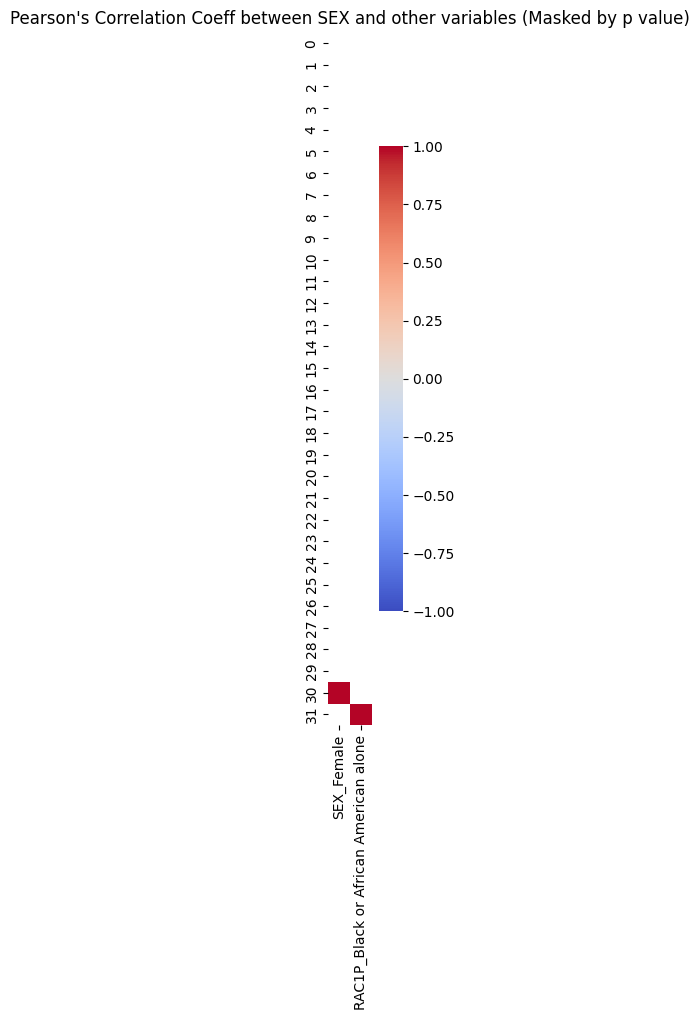

In [16]:
X_train_debiased_p = np.concatenate([X_train_debiased, X_train_p], axis=1)

corr, p = corr_mat(X_train_debiased_p)


# Plot correlations with protected features
plt.figure(figsize=(2,9))
sns.heatmap(corr[:, -2:], cmap="coolwarm", xticklabels=features.columns[-2:],
            mask = p[:, -2:]  > corrected_alpha, vmin=-1, vmax=1, square=True)
plt.title("Pearson's Correlation Coeff between SEX and other variables (Masked by p value)")
plt.show()

In [17]:
lambda_values = np.linspace(0, 1, 11)  # 11 values from 0 to 1
accuracies = pd.DataFrame(columns=['General','Male','Female','White','AA'])
f1_scores = pd.DataFrame(columns=['General','Male','Female','White','AA'])
positive_rates = pd.DataFrame(columns=['General','Male','Female','White','AA'])

y_hat_preds = []

for l in lambda_values:

    #usinng cross validation
    acs, fs, pos = cross_validator_debiased_pca(X_train.astype('float'), y_train, n=5, l=l)
    accuracies = pd.concat([accuracies, pd.DataFrame(acs.mean()).T])
    f1_scores = pd.concat([f1_scores, pd.DataFrame(fs.mean()).T])
    positive_rates = pd.concat([positive_rates, pd.DataFrame(pos.mean()).T])


accuracies.index = lambda_values
f1_scores.index = lambda_values
positive_rates.index = lambda_values

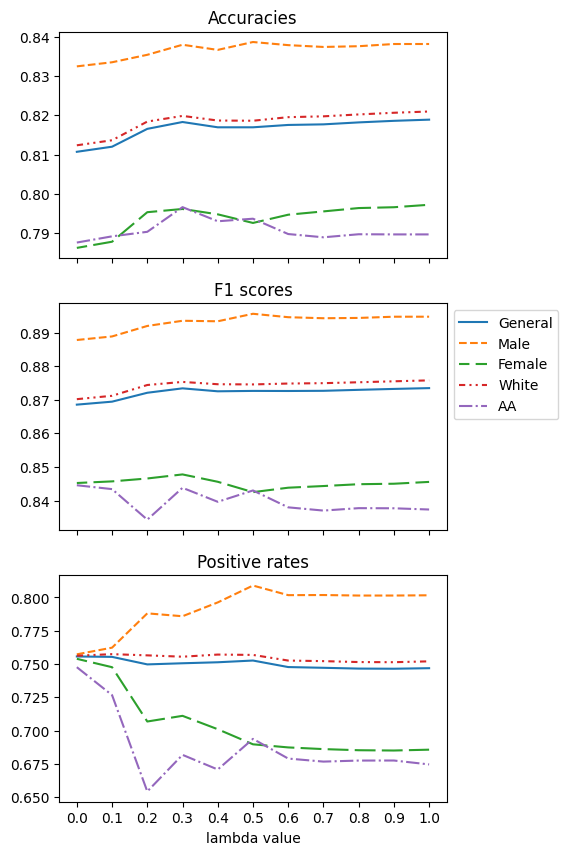

In [18]:
#Cross validation scores

_, ax = plt.subplots(3,1, figsize=(5, 10), sharex=True)
titles = ['Accuracies', 'F1 scores', 'Positive rates']
lines = ['solid', '--', (5, (10, 3)), (0, (3, 2, 1, 2, 1, 2)),'dashdot']


for i, df in enumerate([accuracies, f1_scores, positive_rates]):
    for j in range(5):
        ax[i].plot(df.iloc[:,j], linestyle=lines[j], label=df.columns[j])
        ax[i].set_title(f'{titles[i]}')

ax[1].legend(bbox_to_anchor=(1,1))

plt.xticks(lambda_values, labels=[round(x,1) for x in lambda_values])
plt.xlabel('lambda value')
plt.show()